In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("data/generated/rawLog.csv")

In [2]:
data.head()

,step,action,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,isUnauthorizedOverdraft
0,0,TRANSFER,134342.89,C3901370102,134342.89,0.0,CC6812272942,0.0,134342.89,1,0,0
1,0,CASH_OUT,134342.89,CC6812272942,134342.89,0.0,M8605631338,0.0,0.00,1,0,0
2,0,TRANSFER,28.15,C2703655824,28.15,0.0,CC5153169434,0.0,28.15,1,0,0
3,0,CASH_OUT,28.15,CC5153169434,28.15,0.0,M5417538618,0.0,0.00,1,0,0
4,0,TRANSFER,13.87,C6896625551,13.87,0.0,CC2282429675,0.0,13.87,1,0,0


In [3]:
data.shape

(10510454, 12)

In [4]:
print(
    "Frauds {} {:.3f}% Non-Frauds: {} {:.3f}%".format( 
        len(data[data["isFraud"]==1]), len(data[data["isFraud"]==1])*100 / len(data) ,
        len(data[data["isFraud"]==0]), len(data[data["isFraud"]==0])*100 / len(data) 
))

Frauds 26070 0.248% Non-Frauds: 10484384 99.752%


In [5]:
example_data = pd.read_csv("data/bs140513_032310.csv")
example_data = example_data.drop(columns=["zipcodeOri", "zipMerchant"])
example_data.head()

,step,customer,age,gender,merchant,category,amount,fraud
0,0,'C1093826151','4','M','M348934600','es_transportation',4.55,0
1,0,'C352968107','2','M','M348934600','es_transportation',39.68,0
2,0,'C2054744914','4','F','M1823072687','es_transportation',26.89,0
3,0,'C1760612790','3','M','M348934600','es_transportation',17.25,0
4,0,'C757503768','5','M','M348934600','es_transportation',35.72,0


In [6]:
filtered_data = data.drop(columns=['action', 'oldBalanceOrig', "oldBalanceDest", "isFlaggedFraud", "isUnauthorizedOverdraft" , "newBalanceOrig", "newBalanceDest" ])
filtered_data = filtered_data.rename(columns={"nameOrig": "customer", "nameDest": "merchant", "isFraud" : "fraud"})
filtered_data["age"] = "U"
filtered_data["gender"] = "U"
filtered_data["category"] = np.nan
filtered_data = filtered_data[['step', 'customer', 'age', 'gender', 'merchant', 'category' , 'amount', "fraud"]]

In [7]:
filtered_data.head()

,step,customer,age,gender,merchant,category,amount,fraud
0,0,C3901370102,U,U,CC6812272942,NaN,134342.89,1
1,0,CC6812272942,U,U,M8605631338,NaN,134342.89,1
2,0,C2703655824,U,U,CC5153169434,NaN,28.15,1
3,0,CC5153169434,U,U,M5417538618,NaN,28.15,1
4,0,C6896625551,U,U,CC2282429675,NaN,13.87,1


In [1]:
from data import downloadFromKaggle, normalizing_data, generating3DRNNInput
from data import generateNewFeatures, separateInBatches, separateLabel, separatingTrainTest, normalize3DInput 
from data import read_data, readLocally, saveLocally, readDataFromCloud, saveToCloud 
from visualization import plot_roc_auc, pr_curve, print_confusion_matrix, visualize_data, printModelData, acc_plot, loss_plot, format_vertical_headers

import joblib
import pickle
import pandas as pd
import numpy as np

# !pip install pandas sklearn tensorflow-gpu==2.1.0 keras --user

import pandas, sklearn, tensorflow, keras
print("pandas ",pandas.__version__)
print("sklearn ", sklearn.__version__)
print("tensorflow ", tensorflow.__version__)
print("keras ", keras.__version__)

pandas  1.0.3
sklearn  0.22.1
tensorflow  2.1.0
keras  2.2.4


Using TensorFlow backend.




_ _ _ _ _ _ _ _ _ _  VISUALIZATION BEFORE TRANSFORMATION _ _ _ _ _ _ _ _ _ _ 


Total Fraud vs Non-Fraud Transactions Count: 

0    10484384
1       26070
Name: fraud, dtype: int64

Number of customers:  73094
Ratio of positive frauds vs total dataset: 0.25%

Transactions per customer.
	Mean: 143.8
	Max:  106871 
	Number of Batches Using Max Amount as Fixed Size: 98.3 ~ 99
	Number of Batches Using Mean Amount as Fixed Size: 73094.0 ~ 73094


Samples per Step (day): 
	Mean: 7299 
	Max: 149517 
	Number of Batches Using Max Amount as Fixed Size: 70.3 ~ 71
	Number of Batches Using Mean Amount as Fixed Size: 1440.0 ~ 1440


_ _ _ _ _ _ _ _ _ _  GROUPING TRANSACTIONS BY CUSTOMER ID _ _ _ _ _ _ _ _ _ _ 


LEN:  73094
# Feaures:  8
MIN TRANS PER CUST:  1
MEAN TRANS PER CUST:  143.79366295455168  ~  144
MAX TRANS PER CUST:  106871
EXAMPLE: 

          step  customer  age  gender  merchant  category     amount  fraud
814900     15         0    0       0     73854       NaN  168417.71      0
37

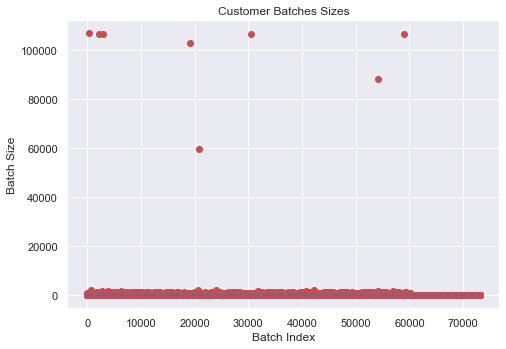



BOX PLOT SHOWING MEAN SIZE OF BATCHES GROUPED BY CUSTOMER ID: 




<Figure size 432x288 with 0 Axes>

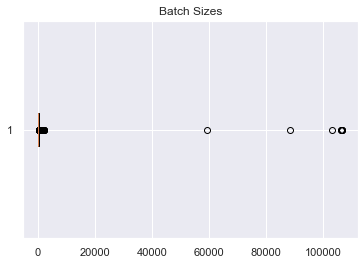

  0% (268 of 73094) |                    | Elapsed Time: 0:00:00 ETA:   0:00:27



_ _ _ _ _ _ _ _ _ _  GENERATING 3D INPUT WITH BATCHES OF SIZE 144 _ _ _ _ _ _ _ _ _ _ 




 98% (72169 of 73094) |################# | Elapsed Time: 0:37:46 ETA:   0:00:00


      The batches are separated by customer id. To be able to use the batches as input for the RNN, 
      it needs to have a static size. That is why the batch size is defined by the average number of 
      transactions done by the customers (144). If one of the customers have done less transactions,
      the rest of the empty space is filled with -1 values. The final array size is (107189, 144, 8). The difference
      between this new more compacted version than previous which uses the max amount of transactions
      per customers is that if a customer has more than the average number of transactions, these 
      transactions are saved in a separate array called left_overs. The left overs are then shaped as
      a 3D array and appended to the main array. The problem with this array which is more efficient in 
      space and has less empty rows is that the mayority of batches are arranged by customer ID but the
      last batches are in disorder, having transactions from many 

<Figure size 432x288 with 0 Axes>

In [9]:
# visualize_data(filtered_data)
rnn_data, smaller_batches_rnn_data = generating3DRNNInput(filtered_data, generate_with_max_size=False) #It generates Memory Error generating array with max size 

In [10]:
# rnn_mod_data                       = generateNewFeatures(rnn_data)
rnn_mod_data                       = generateNewFeatures(smaller_batches_rnn_data)



_ _ _ _ _ _ _ _ _ _  GENERATING NEW FEATURES _ _ _ _ _ _ _ _ _ _ 



        The following features will created using the original Data. 
        The data generated is calculated inside each batch or group
        or transactions grouped by custmer ID. Each calculation takes
        all the data points before the current transaction in which the
        loop index is currently located.

        	 Current day number of transactions  - "curr_day_tr_n"
        	 Average transaction amount per day  - "ave_tr_p_day_amount"
        	 Total average transaction amount 
        	 From the beggining to current time  - "tot_ave_tr_amount"
        	 Is the merchant new?                - "is_mer_new"
        	 What is the common transaction type - "com_tr_type"
        	 What is the common merchant ID      - "com_mer"
        


_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _  




C:\Users\ruben\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\ruben\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\ruben\Documents\Github\mitacs-internship\data.py:289: RuntimeWarning: Mean of empty slice.
  ave_n_trans_per_day       =  np.round(pd.DataFrame(b[:t_i, [step_col, amount_col]][ b[:t_i, step_col ] != -1 ], index=None, columns=None).groupby(by=0).mean().reset_index().values[:, 1].mean() , 2)
C:\Users\ruben\Documents\Github\mitacs-internship\data.py:287: RuntimeWarning: invalid value encountered in greater
  most_common_trans_type    =  np.bincount( b[:t_i,  cat_col ][b[:t_i, cat_col ] > 0].astype(int) ).argmax()  if  len(np.bincount( b[:t_i, cat_col ][b[:t_i, cat_col ] > 0].astype(int) )) > 0 else -1
 99% (107188 of 107189) |############## | Elapsed Time: 13:58:14 ETA:   0:00:00

--- 50298.69 s seconds or 838.31 minutes ---
(107189, 144, 13)
[[ 1.5000e+01  0.0000e+00  0.0000e+00 ... -1.0000e+00 -1.0000e+00
   0.0000e+00]
 [ 1.4100e+02  0.0000e+00  0.0000e+00 ... -1.0000e+00  7.3854e+04
   0.0000e+00]
 [ 1.6500e+02  0.0000e+00  0.0000e+00 ... -1.0000e+00  2.0000e+00
   0.0000e+00]
 ...
 [-1.0000e+00 -1.0000e+00 -1.0000e+00 ... -1.0000e+00  2.0000e+00
  -1.0000e+00]
 [-1.0000e+00 -1.0000e+00 -1.0000e+00 ... -1.0000e+00  2.0000e+00
  -1.0000e+00]
 [-1.0000e+00 -1.0000e+00 -1.0000e+00 ... -1.0000e+00  2.0000e+00
  -1.0000e+00]]


In [ ]:
out_dir = "data/generated/"
import joblib
joblib.dump( rnn_mod_data     , out_dir+"rnn_mod_data.data" ) 
# pickle.dump( rnn_mod_data     , open( out_dir+"rnn_mod_data.data"      , "wb" ) ) 

In [2]:
import joblib
out_dir = "data/generated/"
rnn_mod_data = joblib.load( out_dir+"rnn_mod_data.data" ) 
rnn_mod_data.shape

(107189, 144, 13)

In [3]:
import importlib, data
import numpy as np, pandas as pd
data = importlib.reload(data)
from data import separatePaySimInBatches

X, grouped_X, y, grouped_y         = separatePaySimInBatches(rnn_mod_data, min_batch_size=25)

  0% (17 of 107189) |                    | Elapsed Time: 0:00:00 ETA:   0:21:03



_ _ _ _ _ _ _ _ _ _  SEPARATING IN BATCHES OF 25 _ _ _ _ _ _ _ _ _ _ 



    In the following procedure, the batches separaeted by customer and
    generated in the previous function are iterated. Each transaction
    that has been padded with value of '-1' will be deleted. new batches
    of size '25' will be generated using sliding window through each 
    transaction in every customer batch. Padding will be added for batches 
    with less transactions than the min amount '25'.
    Input Shape:                 (107189, 144, 13)
    Data Shape:                  (107189, 144, 12)
    Label Len:                   (107189, 144)
    Padding Value:               -1
    Column to check for 
    padding values to delete     0
    transaction in the new batch
    


 99% (107185 of 107189) |############### | Elapsed Time: 0:21:37 ETA:   0:00:00

In [4]:
take_indexes = [ isinstance(x,np.ndarray) for x in X ]

In [5]:
X_filtered = X[take_indexes]
y_filtered = y[take_indexes]

In [6]:
X_filtered.shape, y_filtered.shape

((10510454,), (10510454,))

In [ ]:
out_dir = "data/generated/"
import joblib
joblib.dump( X_filtered     , out_dir+"X_filtered.data" ) 
joblib.dump( y_filtered     , out_dir+"y_filtered.data" ) 

In [ ]:
out_dir = "data/generated/"
import joblib
X_filtered = joblib.load( out_dir+"X_filtered.data" ) 
y_filtered = joblib.load( out_dir+"y_filtered.data" ) 
print("X ", X_filtered.shape)
print("y ", y_filtered.shape)

In [ ]:
# take_indexes = [ isinstance(x,np.ndarray) and x.shape == (25,12) for x in X ]
# X_filtered = np.take(X, take_indexes )
# X_filtered.shape
# print(
#      take_indexes[:5], 
# #     len(take_indexes[take_indexes==False]), 
#     len(take_indexes)  
# )
import progressbar
new_size = len(X_filtered) #int(len(X_filtered)*0.9)
bar = progressbar.ProgressBar(max_value= len(X_filtered) )
X_np = np.empty( (new_size, 25, 12) , dtype=np.float)
y_np = np.empty( new_size , dtype=np.float)
print("NEW SHAPE: ", new_size)

i_2 = 0
for i, x in enumerate(X_filtered):
#     if(y_filtered[i] == 0):
#         continue
    i_a2 = 0
    for i_a, a in enumerate(x):
        i_b2 = 0
        for i_b, b in enumerate(a):
            if i_2 < new_size:
                X_np[i_2][i_a2][i_b2] = X_filtered[i][i_a][i_b]
                y_np[i_2] = y_filtered[i]
                i_b2 += 1
        i_a2 += 1
    i_2 += 1
    bar.update(i)


  0% (460 of 10510454) |                 | Elapsed Time: 0:00:00 ETA:   1:16:14

NEW SHAPE:  10510454


 80% (8425509 of 10510454) |##########   | Elapsed Time: 1:00:48 ETA:   0:15:06

In [10]:
empty_padding_value = -1
y_np[y_np==empty_padding_value] = 0

In [11]:
X_np.shape

(10510454, 25, 12)

In [12]:
y_np.shape

(10510454,)

In [13]:
out_dir = "data/generated/"
import joblib
joblib.dump( X_np     , out_dir+"X_unnorm.data" ) 
joblib.dump( y_np     , out_dir+"y.data" ) 
X_np.shape, y_np.shape

((10510454, 25, 12), (10510454,))

In [ ]:
# del rnn_mod_data

In [1]:
import joblib
out_dir = "data/generated/"
X_np = joblib.load( out_dir+"X_unnorm.data" ) 
y    = joblib.load( out_dir+"y.data" ) 

In [2]:
X_np.shape, y.shape

((10510454, 25, 12), (10510454,))

In [5]:
print("N: {} {:.2f}%".format(len(y[y==0]), len(y[y==0])*100/len(y)))

N: 10484384 99.75%


In [6]:
print("P: {} {:.2f}%".format(len(y[y==1]), len(y[y==1])*100/len(y)))

P: 26070 0.25%


In [8]:
from data import normalize3DInput
X_norm                             = normalize3DInput(X_np)



_ _ _ _ _ _ _ _ _ _  SEPARATING TEST & TRAIN _ _ _ _ _ _ _ _ _ _ 


Converting 3D to 2D for easy processing. Batch Sample: 

 [[-1.0000000e+00 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00
  -1.0000000e+00 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00
  -1.0000000e+00 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00]
 [-1.0000000e+00 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00
  -1.0000000e+00 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00
  -1.0000000e+00 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00]
 [-1.0000000e+00 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00
  -1.0000000e+00 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00
  -1.0000000e+00 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00]
 [-1.0000000e+00 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00
  -1.0000000e+00 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00
  -1.0000000e+00 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00]
 [-1.0000000e+00 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00
  -1.0000000e+00 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00


In [9]:
out_dir = "data/generated/"
import joblib
joblib.dump( X_norm     , out_dir+"X_norm.data" ) 

['data/generated/X_norm.data']

In [1]:
out_dir = "data/generated/"
import joblib
X_norm = joblib.load( out_dir+"X_norm.data" ) 
y      = joblib.load( out_dir+"y.data" ) 
X_norm.shape, y.shape

((10510454, 25, 12), (10510454,))

In [3]:
from data import separatingTrainTest
X_train, X_test, y_train, y_test, X_val, y_val = separatingTrainTest(X_norm, y, test_size=0.1, val_size=0.1)



_ _ _ _ _ _ _ _ _ _  SEPARATING TEST & TRAIN _ _ _ _ _ _ _ _ _ _ 




MemoryError: Unable to allocate 16.9 GiB for an array with shape (7567526, 25, 12) and data type float64

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y, 
    test_size=0.2, 
    random_state=42
)


In [4]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8408363, 25, 12), (2102091, 25, 12), (8408363,), (2102091,))

In [ ]:
X_train, X_test, y_val, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    random_state=42
)


In [9]:
print("""SHAPES & KEYS:
X_train          : {} P: {:.2f} N: {:.2f}
y_train          : {}
________________________
X_test           : {} P: {:.2f} N: {:.2f}
y_test           : {}
""".format(
    X_train.shape,  len(y_train[y_train==1])*100/len(y_train),  len(y_train[y_train==0])*100/len(y_train),
    y_train.shape,
    X_test.shape,   len(y_test[y_test==1])*100/len(y_test),  len(y_test[y_test==0])*100/len(y_test),  
    y_test.shape
))

SHAPES & KEYS:
X_train          : (8408363, 25, 12) P: 0.25 N: 99.75
y_train          : (8408363,)
________________________
X_test           : (2102091, 25, 12) P: 0.25 N: 99.75
y_test           : (2102091,)



In [11]:
out_dir = "data/generated/"
import joblib
joblib.dump( X_train      , out_dir+"X_train.data" ) 
joblib.dump( X_test       , out_dir+"X_test.data"  )
joblib.dump( y_train      , out_dir+"y_train.data" )
joblib.dump( y_test       , out_dir+"y_test.data"  )

['data/generated/y_test.data']

In [1]:
out_dir = "data/generated/"
import joblib
X_train = joblib.load( out_dir+"X_train.data" ) 
X_test  = joblib.load( out_dir+"X_test.data"  )
y_train = joblib.load( out_dir+"y_train.data" )
y_test  = joblib.load( out_dir+"y_test.data"  )

print("""SHAPES & KEYS:
X_train          : {} P: {:.2f} N: {:.2f}
y_train          : {}
________________________
X_test           : {} P: {:.2f} N: {:.2f}
y_test           : {}
""".format(
    X_train.shape,  len(y_train[y_train==1])*100/len(y_train),  len(y_train[y_train==0])*100/len(y_train),
    y_train.shape,
    X_test.shape,   len(y_test[y_test==1])*100/len(y_test),  len(y_test[y_test==0])*100/len(y_test),  
    y_test.shape
))

SHAPES & KEYS:
X_train          : (8408363, 25, 12) P: 0.25 N: 99.75
y_train          : (8408363,)
________________________
X_test           : (2102091, 25, 12) P: 0.25 N: 99.75
y_test           : (2102091,)



In [ ]:
from models import RNNModel
import numpy as np
import pandas as pd
import joblib
from data import readLocally
from sklearn.metrics import confusion_matrix
from visualization import plot_roc_auc, pr_curve, format_vertical_headers, print_confusion_matrix, printModelData

gru_param_grid = {
    'modelType': ['GRU'], 
    'dropout': [True],
    'dropout_rate': [0.2], 
    'epochs': [50], 
    'hidden_layer_activation': ['sigmoid'], 
    'hidden_layers': [2], 
    'hidden_layers_neurons': [300], 
    'loss': ['binary_crossentropy'], 
    'optimizer': ['adam'], 
    'output_layer_activation': ['sigmoid'], 
    'rnn_hidden_layers': [1], 
    'rnn_hidden_layers_neurons': [50], 
    'rnn_layer_activation': ['sigmoid']
}
n_batches        = X_train.shape[0]
batch_size       = X_train.shape[1]
n_features       = X_train.shape[2]

out_dir = "data/generated/"
print(n_batches, batch_size, n_features)
checkpoint_dir = out_dir+"gru_paysim_2_rnn_layers_no_l1_checkpoints.h5"
model_dir = out_dir+"gru_paysim_2_rnn_layers_no_l1.h5"

print(checkpoint_dir)
print(model_dir)


gru_model = RNNModel(
  input_shape=( batch_size , n_features  ),
  output_dim = 1,
  param_grid=gru_param_grid,
  scoring=['accuracy', 'precision', 'recall', 'roc_auc', 'f1', 'average_precision' ],  
  refit= "recall",   
  verbose=1,
  output_file= checkpoint_dir,
  early_stopping_monitor="val_recall",
  model_checkpoint_monitor="val_recall"
)

gru_history = gru_model.train( X_train, y_train, X_test, y_test, class_weights=None )
print("SAVING..")
gru_model.model.best_estimator_.model.save( model_dir )

8408363 25 12
data/generated/gru_paysim_2_rnn_layers_no_l1_checkpoints.h5
data/generated/gru_paysim_2_rnn_layers_no_l1.h5


_ _ _ _ _ _ _ _ _ _  CREATING RNN MODEL WITHOUT L1 REGULARIZATION _ _ _ _ _ _ _ _ _ _ 




_ _ _ _ _ _ _ _ _ _  INITIALIZING GRID SEARCH RNN MODEL _ _ _ _ _ _ _ _ _ _ 



        PARAMETERS:
        ________________________________
        input_shape :  (25, 12)
        output_dim  :  1
        main scoring:  recall
        all scoring :  ['accuracy', 'precision', 'recall', 'roc_auc', 'f1', 'average_precision']
        early_stopping_monitor   : val_recall
        model_checkpoint_monitor : val_recall
        verbose: 1
        callbacks: 

[<tensorflow.python.keras.callbacks.EarlyStopping object at 0x7f79e47f5b70>, <tensorflow.python.keras.callbacks.ModelCheckpoint object at 0x7f79e47f5a90>, <tensorflow.python.keras.callbacks.CSVLogger object at 0x7f79e4681be0>, <tensorflow.python.keras.callbacks.TensorBoard object at 0x7f79e4681ba8>, <tensorflow.python.keras.ca

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




_ _ _ _ _ _ _ _ _ _  CREATING ML MODEL _ _ _ _ _ _ _ _ _ _ 



        PARAMETERS:
        ________________________________ 
          rnn_hidden_layers:         1 
          rnn_hidden_layers_neurons: 50 
          hidden_layers:             2 
          hidden_layers_neurons:     300
          loss:                      binary_crossentropy
          optimizer:                 adam
          modelType:                 GRU
          dropout:                   True
          dropout_rate:              0.2
          input_shape:               (25, 12)
          output_dim:                1
          output_layer_activation:   sigmoid
          rnn_layer_activation:      sigmoid
          hidden_layer_activation:   sigmoid
          keras_eval_metric:         [[<tensorflow.python.keras.metrics.TruePositives object at 0x7f79e44d17b8>, <tensorflow.python.keras.metrics.FalsePositives object at 0x7f79e44d1cc0>, <tensorflow.python.keras.metrics.TrueNegatives object at 0x7f79e44d1f98>, <tenso

In [ ]:
X_train.shape